In [39]:
import hdf5storage
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split #데이터 분할을 위해
from sklearn.metrics import confusion_matrix,f1_score,roc_auc_score,classification_report,roc_curve,auc

In [57]:

file='mnist.mat'
mat = hdf5storage.loadmat(file) #mnist.mat 파일 로드

X=pd.DataFrame(mat['X'])
y=pd.DataFrame(mat['y'])

X
#####################################
#size = 7000  #sampling 할 크기 결정
####################################

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.0036,-73.804153,198.205963,0.0,-13.124617,-1.1501,0.0,-0.141633,179.249390,114.661163,...,188.055649,-0.107667,-4.469967,158.381409,-137.100632,27.131416,-2.274633,-0.00065,-12.351267,0.0
1,-0.0036,-73.804153,197.205963,0.0,-13.124617,-1.1501,0.0,-0.141633,179.249390,-44.338833,...,186.055649,-0.107667,-4.469967,123.381416,-137.100632,157.131409,-2.274633,-0.00065,-12.351267,0.0
2,-0.0036,-73.804153,-53.794033,0.0,-13.124617,-1.1501,0.0,-0.141633,-73.750618,-44.338833,...,188.055649,-0.107667,-4.469967,157.381409,-137.100632,-93.868584,-2.274633,-0.00065,-12.351267,0.0
3,-0.0036,-73.804153,86.205963,0.0,-13.124617,-1.1501,0.0,-0.141633,76.249382,208.661163,...,188.055649,-0.107667,-4.469967,157.381409,-137.100632,74.131416,-2.274633,-0.00065,-12.351267,0.0
4,-0.0036,-27.804153,199.205963,0.0,-13.124617,-1.1501,0.0,-0.141633,179.249390,-44.338833,...,188.055649,-0.107667,-4.469967,22.381416,-137.100632,159.131409,-2.274633,-0.00065,-12.351267,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7598,-0.0036,179.195847,0.205967,0.0,-13.124617,-1.1501,0.0,-0.141633,179.249390,-44.338833,...,131.055649,-0.107667,-4.469967,159.381409,115.899368,-93.868584,-2.274633,-0.00065,-12.351267,0.0
7599,-0.0036,-73.804153,-53.794033,0.0,29.875383,-1.1501,0.0,-0.141633,-73.750618,67.661163,...,-64.944351,-0.107667,-4.469967,-93.618584,94.899368,-93.868584,-2.274633,-0.00065,-12.351267,0.0
7600,-0.0036,-73.804153,-53.794033,0.0,-13.124617,-1.1501,0.0,-0.141633,-73.750618,-44.338833,...,-64.944351,-0.107667,-4.469967,-93.618584,-137.100632,-53.868584,-2.274633,-0.00065,-12.351267,0.0
7601,-0.0036,-73.804153,-53.794033,0.0,19.875383,-1.1501,0.0,-0.141633,153.249390,-44.338833,...,-64.944351,-0.107667,-4.469967,158.381409,23.899368,-93.868584,-2.274633,-0.00065,125.648735,0.0


In [58]:
def weight_cal(y):     #원본 데이터 셋의 outlier 비율 계산 함수
    normal_num, abnormal_num=cal(y)   #inlier 0, outlier 1
    abnormal_rate = abnormal_num/(normal_num+abnormal_num)   # outlier 개수 비율
    
    z = pd.DataFrame(mat['y'])
    z.columns=['weight']

    z.loc[z["weight"] == 0] = (1-abnormal_rate)/normal_num   #데이터 1개의 확률값
    z.loc[z["weight"] == 1] = abnormal_rate/abnormal_num
    
    return z
    

In [59]:
def separate_sampling(X,y,z,size):     #sample 크기를 선택할 때 사용
    data=pd.concat([X,y,z],axis=1) #x,y,z 합치기
    data=data.sample(n=size,weights='weight') #가중치를 이용해 sampling함
    del data['weight'] 
    data.columns=[i for i in range(101)] # columns 값 0~100 설정
   
    normal=data.loc[data[100]==0]  #라벨 0은 normal로 
    abnormal=data.loc[data[100]==1] #라벨 1은 abnormal로
    normal.drop([100],axis=1,inplace=True) #
    abnormal.drop([100],axis=1,inplace=True) #
 
    
    return normal,abnormal

In [60]:
def cal(y):    #데이터셋 normal, abnormal 개수 반환
    normal=y.loc[y[0]==0]  #라벨 0은 normal로 
    abnormal=y.loc[y[0]==1] #라벨 1은 abnormal로
    return len(normal), len(abnormal) 

In [61]:
def separate(X,y):  #X,y  
    data=pd.concat([X,y],axis=1) #왼쪽 + 오른쪽으로 합치기
    data.columns=[i for i in range(101)] # columns 값 0~100 설정
   
   
    normal=data.loc[data[100]==0]  #라벨 0은 normal로 
    abnormal=data.loc[data[100]==1] #라벨 1은 abnormal로
    normal.drop([100],axis=1,inplace=True) #
    abnormal.drop([100],axis=1,inplace=True) #
    print(len(normal))
    print(len(abnormal))
    
    return normal,abnormal

In [62]:
def prepare_sets(X,y):
    X=np.array(X)
    y=np.array(y)
    X,X_test,y,y_test=train_test_split(X,y,test_size=0.2) #데이터 분할을 위해
    X_train,X_dev,y_train,y_dev=train_test_split(X,y,test_size=0.25) #검증위해 Training, Validation, Testing로 나눔
    return X_train,y_train,X_dev,y_dev,X_test,y_test

In [63]:
def model(X):
   
    ifor = IsolationForest(n_estimators=100, max_samples=512,contamination=0.0235).fit(X) #모델 생성  
    return ifor

In [64]:
def model_evaluate(ifor,X,y):
    s= -ifor.decision_function(X) # 평균 이상치 점수 
    z=roc_auc_score(y,s)  #실제 라벨값과 이상치 점수로 auc 값 리턴 
    print('AUCROC= ',z) 


In [65]:
def roc_plot(model,X,y):    #AUC 값을 도식화 
    preds= -model.decision_function(X) #평균 이상치 점수
    fpr, tpr, threshold = roc_curve(y, preds)
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [66]:
#z = weight_cal(y)  #가중치로 샘플링할 때 필요
z = cal(y)  #가중치로 샘플링할 때 필요


#normal,abnormal=separate_sampling(X,y,z,size)  #Sampling 할 경우
normal,abnormal=separate(X,y)       #원본 데이터셋 그대로 사용할 경우
X_train,y_train,X_dev,y_dev,X_test,y_test=prepare_sets(X,y)

6903
700


C:\Users\golde\Anaconda3\envs\py3.6\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [67]:
ifor=model(X_train)

In [68]:
scores_n = -ifor.decision_function(normal) # 평균 이상치 점수  
                                           #0.5-ifor.decision_function(normal)
scores_ab= -ifor.decision_function(abnormal)

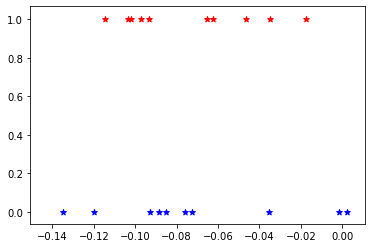

In [69]:
for i in range(10):
        plt.scatter(scores_n[i],0,color='blue',marker='*')

for i in range(10):
     plt.scatter(scores_ab[i],1,color='red',marker='*')

In [70]:
print('TRAIN')
model_evaluate(ifor,X_train,y_train)

TRAIN
AUCROC=  0.7912932913538386


In [71]:
print('DEV')
model_evaluate(ifor,X_dev,y_dev)

DEV
AUCROC=  0.7895686614560752


In [72]:
print('TEST')
model_evaluate(ifor,X_test,y_test)

TEST
AUCROC=  0.7606027397260273


roc_plot


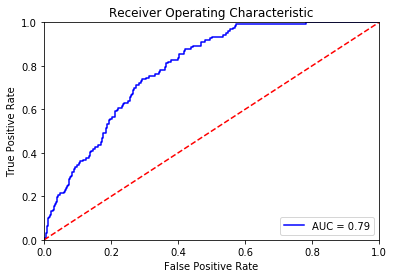

In [73]:
print('roc_plot')
roc_plot(ifor,X_dev,y_dev)